## Numerical simulation of the dynamics of the optical tweezers

The motion of the bead controlled by the optical tweezers is described by the differential equation
$$
\frac{\mathrm dx(t)}{\mathrm dt} = -k x(t) + \eta(t),
$$

with $k$ the stiffness of the harmonic trap potential and $\eta(t) = \frac{\mathrm dB}{\mathrm dt}$ white noise. First we define the function $\eta$ and set initial parameters.

In [74]:
# Brownian noise
brownian = function(sigma){
    rnorm(1, mean = 0, sd=sigma)
}

# Method to use. 1 = Euler, 2 = AR(1)
method = 2

k = c(106.00, 119.25) # Stiffness of the harmonic potential in x, y

# Initial points x0, y0 for the particle
# Because the process is Markov, we want to start from a position created with the equilibrium state variance.
# If this is correct, the variance of the resulting coordinates should be the same.
optimal_var = 1/(2*k)
x0 = rnorm(1, sd=sqrt(optimal_var[1]) )
y0 = rnorm(1, sd=sqrt(optimal_var[2]) )

fps = 5000

startt = 0 # Starting time
endt = 20 # End time

# Multiply the frequency for the dynamics simulator (-> discard 1/freqmult of the points in the end)
freqmult = 10

nsteps = (endt-startt)*fps*freqmult
dt = (endt - startt)/nsteps
steps = matrix(,nsteps,2)
sample = seq(1,nsteps,freqmult)
list(x0 = x0, y0=y0, steps = nsteps, timestep=dt, points = length(sample))

$x0
[1] 0.154977

$y0
[1] 0.07782593

$steps
[1] 1e+06

$timestep
[1] 2e-05

$points
[1] 100000

We can use the Euler method to solve the differential equation iteratively for the given number of steps:
$$
\begin{align}
\Delta x_{n-1} &= -k x_{n-1} + \Delta B \\
x_n &= x_{n-1} + \Delta x_{n-1}
\end{align}
$$

or we can directly use the discrete AR(1) model:

$$
x_{n+1} = \alpha x_n + z_n
$$

where
$$
\begin{align}
\alpha &= e^{-k \Delta t}, \\
\mathrm{var}(z_n) &= (1-\alpha^2) \mathrm{var}(x_n)
\end{align}
$$

In [75]:
steps[1,] = c(x0, y0)

if(method == 2){
    alpha = exp( -k * dt )
    sigma = sqrt((1 - alpha^2) * optimal_var)
}
alpha
sigma

[1] 0.9978822 0.9976178

[1] 0.004467400 0.004466808

In [76]:
for(i in 2:nsteps){
    if(method == 1){ # Euler
        delta = -k * steps[i-1,] * dt + c(brownian(sqrt(dt)), brownian(sqrt(dt)))
        steps[i,] = steps[i-1,] + delta
    }
    else
    { # AR(1)
        steps[i,] = alpha * steps[i-1,] + c(brownian(sigma[1]), brownian(sigma[2]))
    }
}

In [77]:
freq = fps*2*pi
traj = ts(steps[sample,], frequency = freq)
xvar = var(traj[,1])
yvar = var(traj[,2])
list(xmean = mean(traj[,1]), xvariance= xvar,
     ymean = mean(traj[,2]), yvariance=yvar,
     xvarratio = xvar*(2*k[1]), yvarratio = yvar*(2*k[1])) # These should be close to 1

$xmean
[1] -0.001270563

$xvariance
[1] 0.00474234

$ymean
[1] -0.001768786

$yvariance
[1] 0.004145391

$xvarratio
[1] 1.005376

$yvarratio
[1] 0.8788229

An estimate for the stiffness $k$ should be obtainable from the variance in the coordinates, since
$$
k \sim \frac{k_b T}{2\sigma^2}
$$

In [78]:
#m_per_px = 9*10^(-9)
m_per_px = 10^(-7)
kb = 1.38064852 * 10^(-23) # Boltzmann constant
T = 293 # Ambient temperature
r = 3*10^(-6) # Radius of the bead
eta = 1^(-3)
beta = 6*pi*r*eta

kx = (kb*T)/(2*xvar*m_per_px^2)
ky = (kb*T)/(2*yvar*m_per_px^2)

list(kx = kx, ky = ky,
     xkratio = beta*k[1]/kx,
     ykratio = beta*k[2]/ky
     )

$kx
[1] 4.265088e-05

$ky
[1] 4.879274e-05

$xkratio
[1] 140.5401

$ykratio
[1] 138.2056

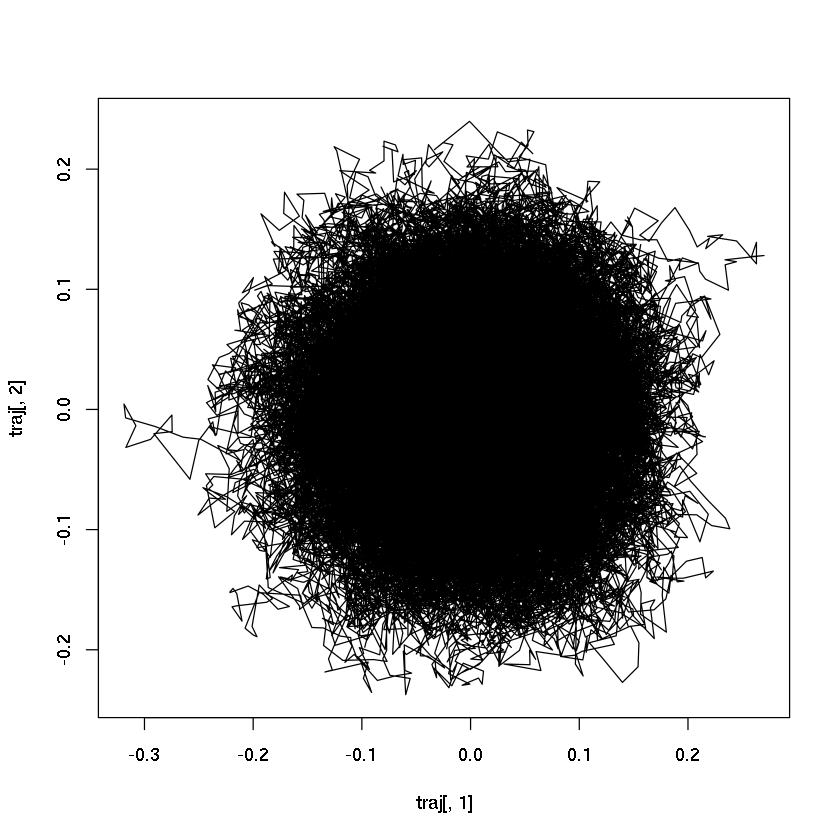

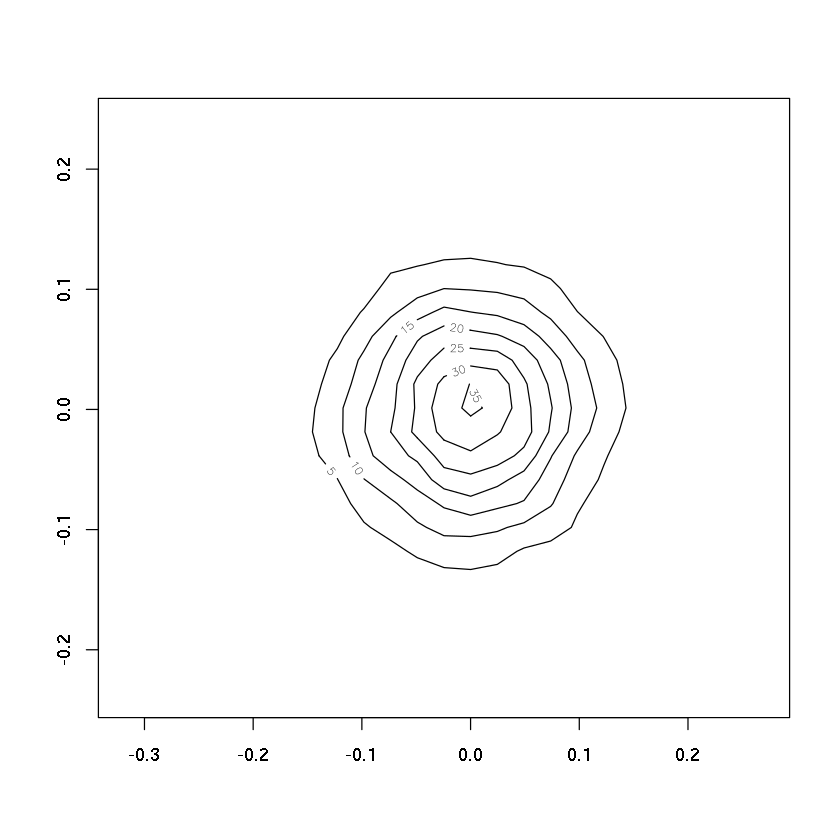

In [79]:
plot(traj[,1], traj[,2], type='l')
library('MASS')
contour(kde2d(traj[,1], traj[,2]))

In [80]:
dnsx = density(traj[,1])
dnsy = density(traj[,2])

acfx = acf(traj[,1], lag=1000, plot=FALSE)
acfy = acf(traj[,2], lag=1000, plot=FALSE)

#plot(acfx$acf, log='y', type='l')
#plot(acfy$acf, log='y', type='l')

In [85]:
plotpoints = 1:3000
acfidx = 1:150

postscript('img/everything_modeled.eps')
layout(matrix(1:6,2,3))

plot(traj[,1]+0.3, axes=FALSE, ylim = c(2*min(traj[,1]),2*max(traj[,2])), ann=FALSE)
lines(traj[,2]-0.3)

plot(traj[plotpoints,1], traj[plotpoints,2], type='l', axes=FALSE, asp=1, ann=FALSE)

plot(dnsx, lwd = 2, ann=FALSE, axes=TRUE)
lines(dnsx$x,dnorm(dnsx$x,mean = mean(traj[,1]),sd = sd(traj[,1])),col='red', lwd = 2)

plot(acfx$lag[acfidx], log(acfx$acf[acfidx]), log='', type='l', ann=FALSE, axes=TRUE)

plot(dnsy, lwd = 2, ann=FALSE, axes=TRUE)
lines(dnsy$x,dnorm(dnsy$x,mean = mean(traj[,2]),sd = sd(traj[,2])),col='red', lwd = 2)

plot(acfy$lag[acfidx], log(acfy$acf[acfidx]), log='', type='l', ann=FALSE, axes=TRUE)

dev.off()

png 
  2

In [82]:
linpart = 1:100

ax = seq(0, (length(linpart)-1)*(1/fps), 1/fps)
logacfx = log(acfx$acf[linpart])
fitx = lm(logacfx ~ ax + 0)
fitx$coefficients

logacfy = log(acfy$acf[linpart])
fity = lm(logacfy ~ ax + 0)
fity$coefficients

list(xkratio = fitx$coefficients['ax']/k[1], ykratio = fity$coefficients['ax']/k[2])

ax 
-109.3714

ax 
-138.6105

$xkratio
       ax 
-1.031806 

$ykratio
       ax 
-1.162352

In [83]:
kpar = c(16,16)
sx = spectrum(traj[,1], plot=FALSE, spans=kpar)
sy = spectrum(traj[,2], plot=FALSE, spans=kpar)

# Initial values
sigma0 = 1
k0 = 100

# Extract values to fit to
specx = sx$spec
freqx = sx$freq

# Fit the fourier transform of acov(x) (acov(y))
fitx = nls(specx ~ (sigma^2)/(freqx^2 + k^2),
                 start = list(sigma = sigma0, k = k0))
fitx

specy = sy$spec
freqy = sy$freq

fity = nls(specy ~ (sigma^2)/(freqx^2 + k^2),
                 start = list(sigma = sigma0, k = k0))
fity

Nonlinear regression model
  model: specx ~ (sigma^2)/(freqx^2 + k^2)
   data: parent.frame()
   sigma        k 
  0.4184 113.8691 
 residual sum-of-squares: 2.501e-09

Number of iterations to convergence: 7 
Achieved convergence tolerance: 2.085e-06

Nonlinear regression model
  model: specy ~ (sigma^2)/(freqx^2 + k^2)
   data: parent.frame()
  sigma       k 
  0.443 144.451 
 residual sum-of-squares: 2.332e-09

Number of iterations to convergence: 6 
Achieved convergence tolerance: 8.254e-06

$xkratio
       k 
1.074237 

$ykratio
       k 
1.211328

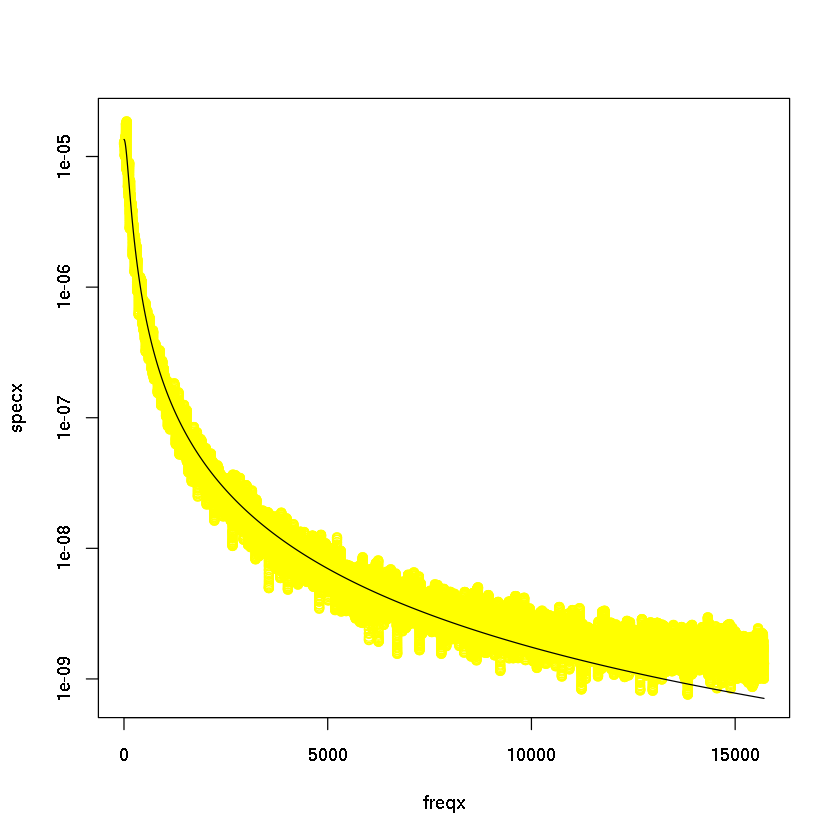

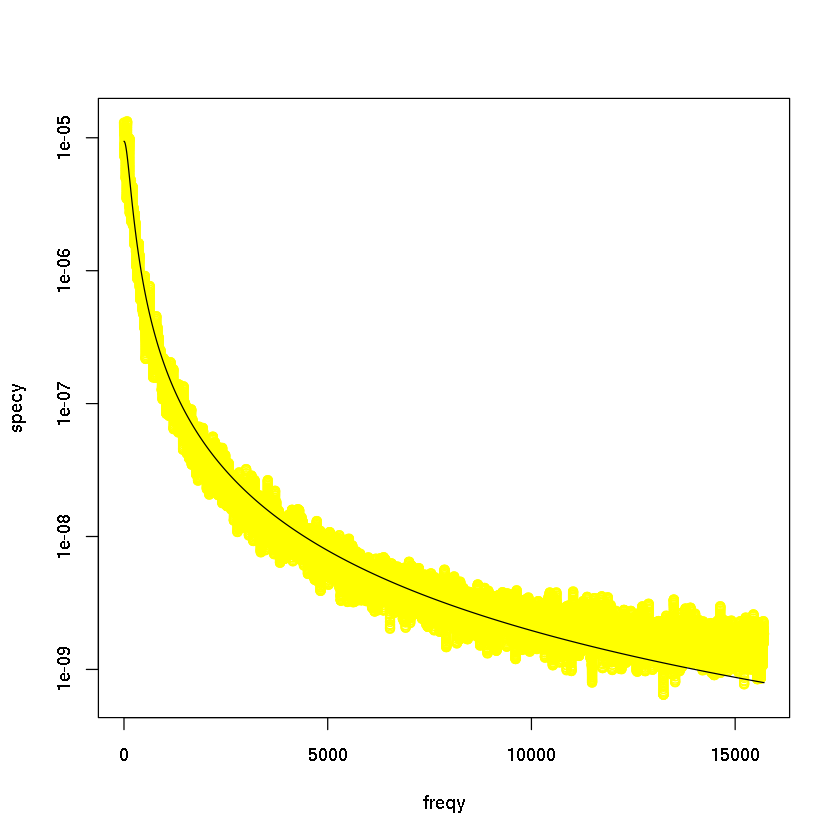

In [84]:
coefsx = coef(fitx)
coefsy = coef(fity)
list(xkratio = coefsx['k']/k[1], ykratio = coefsy['k']/k[2])

plot(freqx, specx, col='yellow', log='y')
lines(freqx, (coefsx['sigma']^2)/(freqx^2+coefsx['k']^2), type='l')

plot(freqy, specy, col='yellow', log='y')
lines(freqy, (coefsy['sigma']^2)/(freqy^2+coefsy['k']^2), type='l')